In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np
import torch, os
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data 
import torch.optim as optim
from torchvision.models import alexnet, resnet, inception 
from torchvision import datasets, transforms, models
import pandas as pd

In [2]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#### CIFAR10

In [3]:
transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


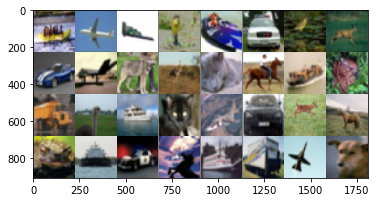

 ship
plane
plane
 bird
 ship
  car
 bird
 deer
  car
plane
  dog
 bird
  cat
horse
 ship
 deer
truck
 bird
 ship
  cat
plane
  car
 deer
horse
 frog
 ship
  car
horse
 ship
truck
plane
  dog


In [4]:
# Get some random training images.
dataiter = iter(trainloader)
images, labels = dataiter.next()
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print('\n'.join('%5s' % classes[labels[j]] for j in range(32)))

#### Sign Language

In [5]:
data_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

signset = datasets.ImageFolder(root='sign_language/', 
                                transform=data_transform)
trainlen = int(0.8*len(signset.samples))
testlen = len(signset.samples) - trainlen
trainset, testset = torch.utils.data.random_split(signset,[trainlen, testlen])
trainloader = torch.utils.data.DataLoader(trainset.dataset, batch_size=4,
                                          shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(testset.dataset, batch_size=4,
                                          shuffle=False, num_workers=1)
classes = trainset.dataset.classes

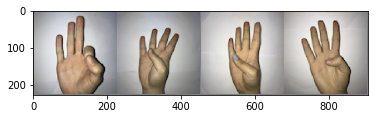

    9,    4,    4,    4


In [6]:
# Get some random training images.
dataiter = iter(trainloader)
images, labels = dataiter.next()
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(','.join('%5s' % int(labels[j]) for j in range(4)))

#### Choose a Device

In [7]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


## AlexNet

#### Network Definition

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.Sigmoid(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.Sigmoid(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [8]:
net = alexnet(num_classes=len(classes))    # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

#### Optimizer and Loss Function

In [9]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  
#opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9 0.99))

#### Training Procedure

In [10]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.
start = time.time()
for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

end = time.time()
print(end - start)
print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.303
[epoch: 0, i:   199] avg mini-batch loss: 2.305
[epoch: 0, i:   299] avg mini-batch loss: 2.303
[epoch: 0, i:   399] avg mini-batch loss: 2.304
[epoch: 0, i:   499] avg mini-batch loss: 2.304
[epoch: 1, i:    99] avg mini-batch loss: 2.303
[epoch: 1, i:   199] avg mini-batch loss: 2.302
[epoch: 1, i:   299] avg mini-batch loss: 2.304
[epoch: 1, i:   399] avg mini-batch loss: 2.303
[epoch: 1, i:   499] avg mini-batch loss: 2.304
[epoch: 2, i:    99] avg mini-batch loss: 2.302
[epoch: 2, i:   199] avg mini-batch loss: 2.303
[epoch: 2, i:   299] avg mini-batch loss: 2.303
[epoch: 2, i:   399] avg mini-batch loss: 2.303
[epoch: 2, i:   499] avg mini-batch loss: 2.302
[epoch: 3, i:    99] avg mini-batch loss: 2.299
[epoch: 3, i:   199] avg mini-batch loss: 2.301
[epoch: 3, i:   299] avg mini-batch loss: 2.303
[epoch: 3, i:   399] avg mini-batch loss: 2.300
[epoch: 3, i:   499] avg mini-batch loss: 2.299
[epoch: 4, i:    99] avg mini-batch loss

#### Training Loss Curve

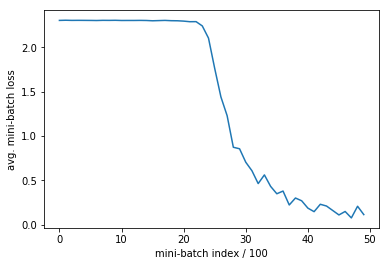

In [11]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

#### Evaluate on Test Dataset

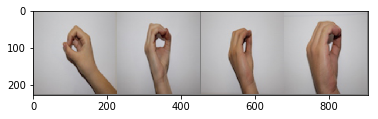

GroundTruth:      0     0     0     0
Predicted:      0     0     0     0


In [12]:
# Check several images.
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [13]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 95 %


In [14]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 99 %
Accuracy of     1 : 98 %
Accuracy of     2 : 90 %
Accuracy of     3 : 99 %
Accuracy of     4 : 92 %
Accuracy of     5 : 99 %
Accuracy of     6 : 90 %
Accuracy of     7 : 94 %
Accuracy of     8 : 99 %
Accuracy of     9 : 97 %


In [ ]:
torch.save(net.state_dict(), 'alexnet_sign_language_state_dict')

## ResNet

#### Network Definition

In [15]:
rnet = resnet.resnet18(num_classes=len(classes))    # Create the network instance.
rnet.to(device)  # Move the network parameters to the specified device.

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

#### Optimizer and Loss Function

In [16]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(rnet.parameters(), lr=0.001, momentum=0.9) 

#### Training Procedure

In [17]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.
start = time.time()
for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = rnet(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0
            
end = time.time()
print(end - start)
print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.473
[epoch: 0, i:   199] avg mini-batch loss: 2.337
[epoch: 0, i:   299] avg mini-batch loss: 1.897
[epoch: 0, i:   399] avg mini-batch loss: 1.668
[epoch: 0, i:   499] avg mini-batch loss: 1.275
[epoch: 1, i:    99] avg mini-batch loss: 1.056
[epoch: 1, i:   199] avg mini-batch loss: 0.929
[epoch: 1, i:   299] avg mini-batch loss: 0.719
[epoch: 1, i:   399] avg mini-batch loss: 0.644
[epoch: 1, i:   499] avg mini-batch loss: 0.548
[epoch: 2, i:    99] avg mini-batch loss: 0.416
[epoch: 2, i:   199] avg mini-batch loss: 0.364
[epoch: 2, i:   299] avg mini-batch loss: 0.350
[epoch: 2, i:   399] avg mini-batch loss: 0.285
[epoch: 2, i:   499] avg mini-batch loss: 0.297
[epoch: 3, i:    99] avg mini-batch loss: 0.245
[epoch: 3, i:   199] avg mini-batch loss: 0.239
[epoch: 3, i:   299] avg mini-batch loss: 0.295
[epoch: 3, i:   399] avg mini-batch loss: 0.219
[epoch: 3, i:   499] avg mini-batch loss: 0.157
[epoch: 4, i:    99] avg mini-batch loss

#### Training Loss Curve

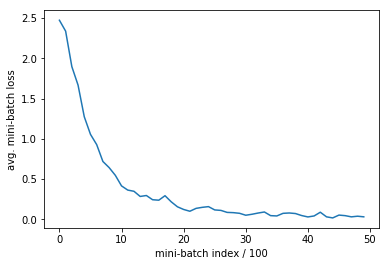

In [18]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

#### Evaluate on Test Dataset

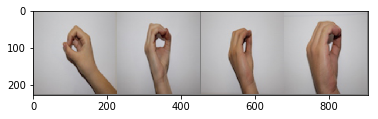

GroundTruth:      0     0     0     0
Predicted:      4     9     0     9


In [19]:
# Check several images.
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = rnet(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [20]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = rnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 50 %


In [21]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = rnet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 48 %
Accuracy of     1 : 22 %
Accuracy of     2 : 57 %
Accuracy of     3 : 40 %
Accuracy of     4 : 66 %
Accuracy of     5 : 23 %
Accuracy of     6 : 71 %
Accuracy of     7 : 58 %
Accuracy of     8 : 44 %
Accuracy of     9 : 71 %


In [ ]:
torch.save(rnet.state_dict(), 'resnet_sign_language_state_dict')